# Task 1 Assessment: Análisis de Resultados

## Evaluación de Topología MetaFeatX

Basado en el paper METABU: "Learning Meta-Features for AutoML" (ICLR 2022)

Este notebook analiza los resultados del Task 1, comparando los vecinos más cercanos basados en representaciones MetaFeatX con los basados en representaciones objetivo usando NDCG.


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import os
warnings.filterwarnings('ignore')

# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Colores para los métodos
COLORS = {
    'metafeatx': '#2E86AB',
    'handcrafted': '#A23B72'
}


In [22]:
# Cargar resultados
script_dir = os.path.dirname(os.path.abspath(''))
if 'notebooks' in os.getcwd():
    results_path = '../data/task1_assessment_results.csv'
else:
    results_path = 'data/task1_assessment_results.csv'

df = pd.read_csv(results_path)
print(f"Total de evaluaciones: {len(df)}")
print(f"Tareas evaluadas: {df['task_id'].nunique()}")
print(f"Algoritmos: {df['pipeline'].unique()}")
print(f"Tipos de meta-features: {df['feature_type'].unique()}")
df.head()


Total de evaluaciones: 384
Tareas evaluadas: 64
Algoritmos: ['adaboost' 'random_forest' 'libsvm_svc']
Tipos de meta-features: ['metafeatx' 'handcrafted']


,task_id,feature_type,pipeline,ndcg@5,ndcg@10,ndcg@20
0,3,metafeatx,adaboost,0.4,0.5,0.45
1,6,metafeatx,adaboost,0.6,0.5,0.65
2,11,metafeatx,adaboost,0.4,0.6,0.75
3,12,metafeatx,adaboost,0.2,0.5,0.75
4,14,metafeatx,adaboost,0.4,0.3,0.70


## Resumen Estadístico por Algoritmo y Tipo de Meta-feature


In [23]:
# Análisis estadístico detallado
print("="*70)
print("RESUMEN ESTADÍSTICO")
print("="*70)

for pipeline in sorted(df['pipeline'].unique()):
    print(f"\n{pipeline.upper()}:")
    for feature_type in sorted(df['feature_type'].unique()):
        subset = df[(df['pipeline'] == pipeline) & (df['feature_type'] == feature_type)]
        if not subset.empty:
            print(f"\n  {feature_type.upper()}:")
            for k in [5, 10, 20]:
                values = subset[f'ndcg@{k}'].values
                print(f"    NDCG@{k}:")
                print(f"      Media:    {values.mean():.4f}")
                print(f"      Mediana:  {np.median(values):.4f}")
                print(f"      Std:      {values.std():.4f}")
                print(f"      Min:      {values.min():.4f}")
                print(f"      Max:      {values.max():.4f}")
                print(f"      Q25:      {np.percentile(values, 25):.4f}")
                print(f"      Q75:      {np.percentile(values, 75):.4f}")


RESUMEN ESTADÍSTICO

ADABOOST:

  HANDCRAFTED:
    NDCG@5:
      Media:    0.3531
      Mediana:  0.4000
      Std:      0.1489
      Min:      0.2000
      Max:      0.6000
      Q25:      0.2000
      Q75:      0.4000
    NDCG@10:
      Media:    0.3594
      Mediana:  0.4000
      Std:      0.1487
      Min:      0.1000
      Max:      0.7000
      Q25:      0.2750
      Q75:      0.5000
    NDCG@20:
      Media:    0.4789
      Mediana:  0.4500
      Std:      0.1328
      Min:      0.2000
      Max:      0.8000
      Q25:      0.4000
      Q75:      0.6000

  METAFEATX:
    NDCG@5:
      Media:    0.3750
      Mediana:  0.4000
      Std:      0.1953
      Min:      0.2000
      Max:      0.8000
      Q25:      0.2000
      Q75:      0.6000
    NDCG@10:
      Media:    0.4094
      Mediana:  0.4000
      Std:      0.2337
      Min:      0.1000
      Max:      0.8000
      Q25:      0.2000
      Q75:      0.6000
    NDCG@20:
      Media:    0.5547
      Mediana:  0.6000
      Std:  

## Comparación MetaFeatX vs Hand-crafted


In [24]:
# Análisis de significancia estadística
print("="*70)
print("SIGNIFICANCIA ESTADÍSTICA: MetaFeatX vs Hand-crafted")
print("="*70)

comparison_results = []

for pipeline in sorted(df['pipeline'].unique()):
    print(f"\n{pipeline.upper()}:")
    mf = df[(df['pipeline'] == pipeline) & (df['feature_type'] == 'metafeatx')]
    hc = df[(df['pipeline'] == pipeline) & (df['feature_type'] == 'handcrafted')]
    
    for k in [5, 10, 20]:
        mf_vals = mf[f'ndcg@{k}'].values
        hc_vals = hc[f'ndcg@{k}'].values
        
        # Test t de Student (pareado)
        t_stat, p_value_t = stats.ttest_rel(mf_vals, hc_vals)
        
        # Wilcoxon signed-rank test (más robusto)
        w_stat, p_value_w = stats.wilcoxon(mf_vals, hc_vals)
        
        improvement = mf_vals.mean() - hc_vals.mean()
        improvement_pct = (improvement / hc_vals.mean()) * 100
        
        sig_t = '***' if p_value_t < 0.001 else '**' if p_value_t < 0.01 else '*' if p_value_t < 0.05 else 'ns'
        sig_w = '***' if p_value_w < 0.001 else '**' if p_value_w < 0.01 else '*' if p_value_w < 0.05 else 'ns'
        
        print(f"  NDCG@{k}:")
        print(f"    MetaFeatX:   {mf_vals.mean():.4f} ± {mf_vals.std():.4f}")
        print(f"    Hand-crafted: {hc_vals.mean():.4f} ± {hc_vals.std():.4f}")
        print(f"    Mejora:       {improvement:+.4f} ({improvement_pct:+.2f}%)")
        print(f"    t-test:       p={p_value_t:.6f} {sig_t}")
        print(f"    Wilcoxon:     p={p_value_w:.6f} {sig_w}")
        
        comparison_results.append({
            'pipeline': pipeline,
            'k': k,
            'metafeatx_mean': mf_vals.mean(),
            'handcrafted_mean': hc_vals.mean(),
            'improvement': improvement,
            'improvement_pct': improvement_pct,
            'p_value_t': p_value_t,
            'p_value_w': p_value_w,
            'significant_t': sig_t,
            'significant_w': sig_w
        })

comparison_df = pd.DataFrame(comparison_results)


SIGNIFICANCIA ESTADÍSTICA: MetaFeatX vs Hand-crafted

ADABOOST:
  NDCG@5:
    MetaFeatX:   0.3750 ± 0.1953
    Hand-crafted: 0.3531 ± 0.1489
    Mejora:       +0.0219 (+6.19%)
    t-test:       p=0.349251 ns
    Wilcoxon:     p=0.443471 ns
  NDCG@10:
    MetaFeatX:   0.4094 ± 0.2337
    Hand-crafted: 0.3594 ± 0.1487
    Mejora:       +0.0500 (+13.91%)
    t-test:       p=0.092777 ns
    Wilcoxon:     p=0.182594 ns
  NDCG@20:
    MetaFeatX:   0.5547 ± 0.2320
    Hand-crafted: 0.4789 ± 0.1328
    Mejora:       +0.0758 (+15.82%)
    t-test:       p=0.006923 **
    Wilcoxon:     p=0.009114 **

LIBSVM_SVC:
  NDCG@5:
    MetaFeatX:   0.2812 ± 0.1402
    Hand-crafted: 0.2781 ± 0.1205
    Mejora:       +0.0031 (+1.12%)
    t-test:       p=0.882872 ns
    Wilcoxon:     p=0.785061 ns
  NDCG@10:
    MetaFeatX:   0.3125 ± 0.1728
    Hand-crafted: 0.2875 ± 0.1023
    Mejora:       +0.0250 (+8.70%)
    t-test:       p=0.256276 ns
    Wilcoxon:     p=0.243511 ns
  NDCG@20:
    MetaFeatX:   0.4773 ± 0

## Visualizaciones


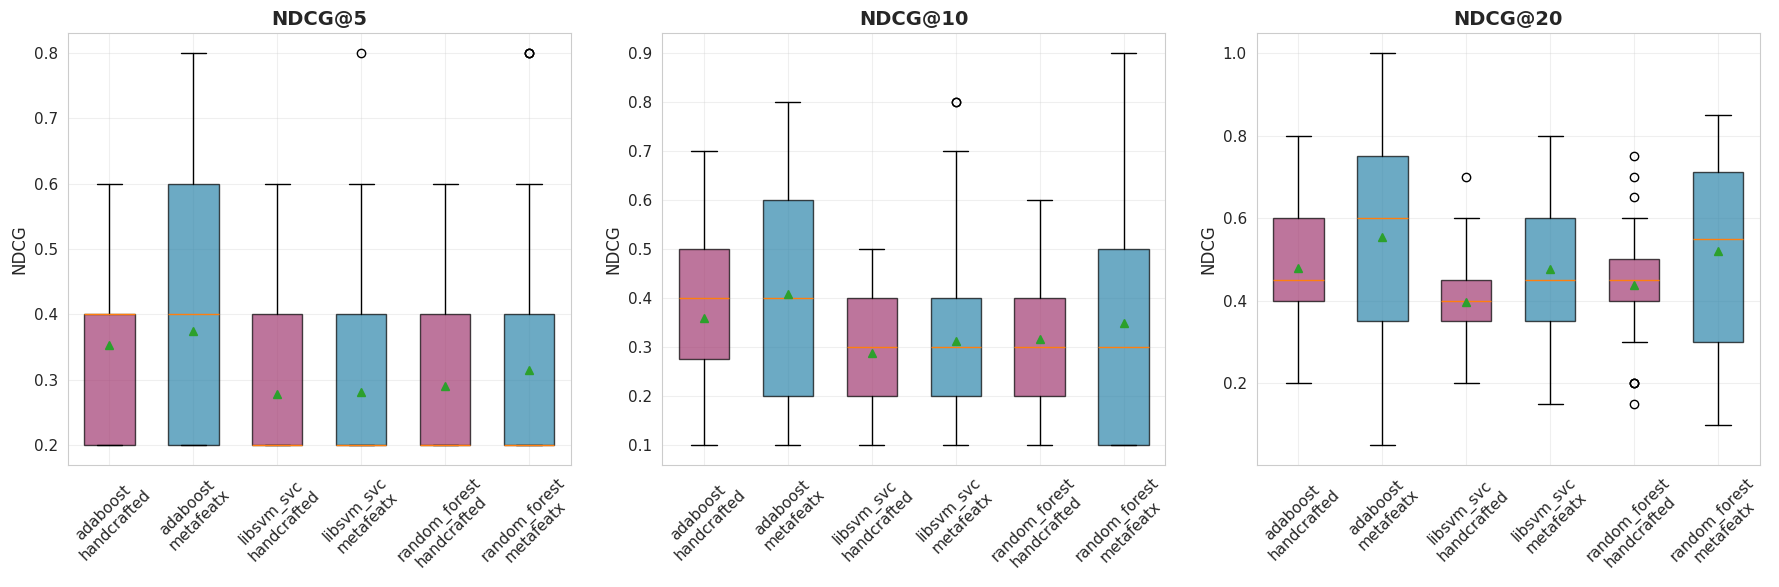

In [25]:
# 1. Box plots comparativos
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, k in enumerate([5, 10, 20]):
    ax = axes[idx]
    
    # Preparar datos
    plot_data = []
    labels = []
    
    for pipeline in sorted(df['pipeline'].unique()):
        for feature_type in ['handcrafted', 'metafeatx']:
            subset = df[(df['pipeline'] == pipeline) & (df['feature_type'] == feature_type)]
            if not subset.empty:
                plot_data.append(subset[f'ndcg@{k}'].values)
                labels.append(f"{pipeline}\n{feature_type}")
    
    bp = ax.boxplot(plot_data, labels=labels, patch_artist=True, 
                    widths=0.6, showmeans=True)
    
    # Colorear boxes
    for i, patch in enumerate(bp['boxes']):
        if 'metafeatx' in labels[i]:
            patch.set_facecolor(COLORS['metafeatx'])
            patch.set_alpha(0.7)
        else:
            patch.set_facecolor(COLORS['handcrafted'])
            patch.set_alpha(0.7)
    
    ax.set_title(f'NDCG@{k}', fontsize=14, fontweight='bold')
    ax.set_ylabel('NDCG', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


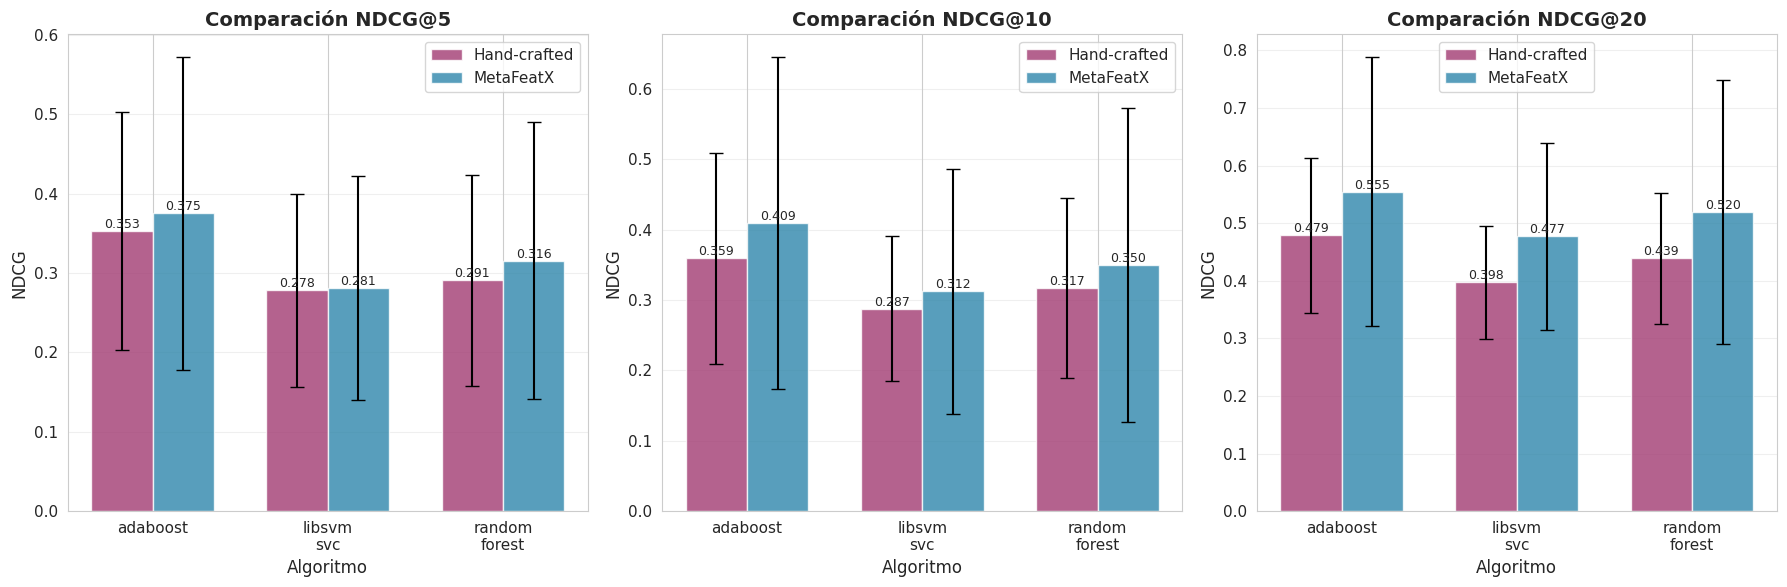

In [26]:
# 2. Comparación directa de medias
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, k in enumerate([5, 10, 20]):
    ax = axes[idx]
    
    pipelines = sorted(df['pipeline'].unique())
    x = np.arange(len(pipelines))
    width = 0.35
    
    metafeatx_means = []
    handcrafted_means = []
    metafeatx_stds = []
    handcrafted_stds = []
    
    for pipeline in pipelines:
        mf_subset = df[(df['pipeline'] == pipeline) & (df['feature_type'] == 'metafeatx')]
        hc_subset = df[(df['pipeline'] == pipeline) & (df['feature_type'] == 'handcrafted')]
        
        metafeatx_means.append(mf_subset[f'ndcg@{k}'].mean())
        handcrafted_means.append(hc_subset[f'ndcg@{k}'].mean())
        metafeatx_stds.append(mf_subset[f'ndcg@{k}'].std())
        handcrafted_stds.append(hc_subset[f'ndcg@{k}'].std())
    
    bars1 = ax.bar(x - width/2, handcrafted_means, width, label='Hand-crafted', 
                   color=COLORS['handcrafted'], alpha=0.8, yerr=handcrafted_stds, capsize=5)
    bars2 = ax.bar(x + width/2, metafeatx_means, width, label='MetaFeatX', 
                   color=COLORS['metafeatx'], alpha=0.8, yerr=metafeatx_stds, capsize=5)
    
    ax.set_xlabel('Algoritmo', fontsize=12)
    ax.set_ylabel('NDCG', fontsize=12)
    ax.set_title(f'Comparación NDCG@{k}', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([p.replace('_', '\n') for p in pipelines])
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Agregar valores en las barras
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


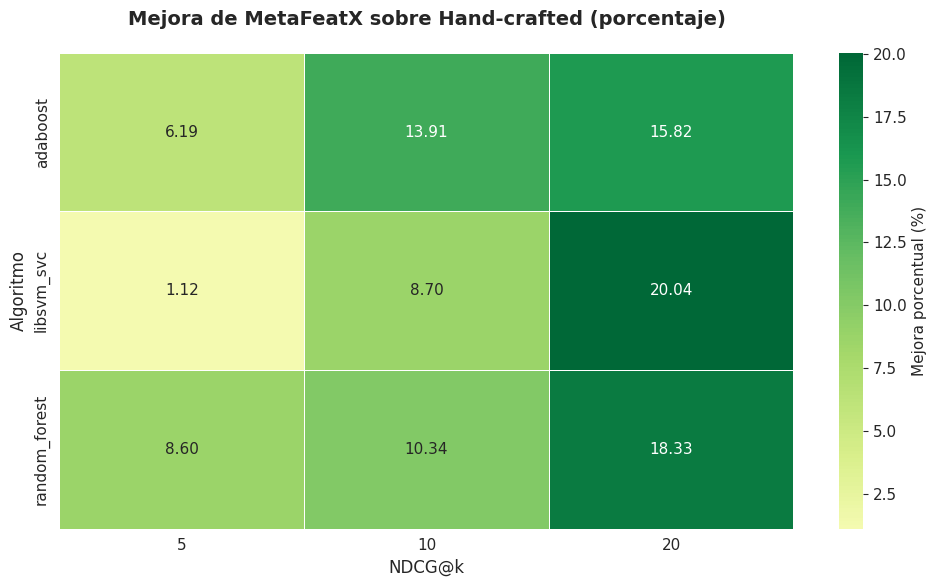

In [27]:
# 3. Heatmap de mejoras porcentuales
pivot_data = comparison_df.pivot(index='pipeline', columns='k', values='improvement_pct')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='RdYlGn', center=0, 
            cbar_kws={'label': 'Mejora porcentual (%)'}, linewidths=0.5)
plt.title('Mejora de MetaFeatX sobre Hand-crafted (porcentaje)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('NDCG@k', fontsize=12)
plt.ylabel('Algoritmo', fontsize=12)
plt.tight_layout()
plt.show()


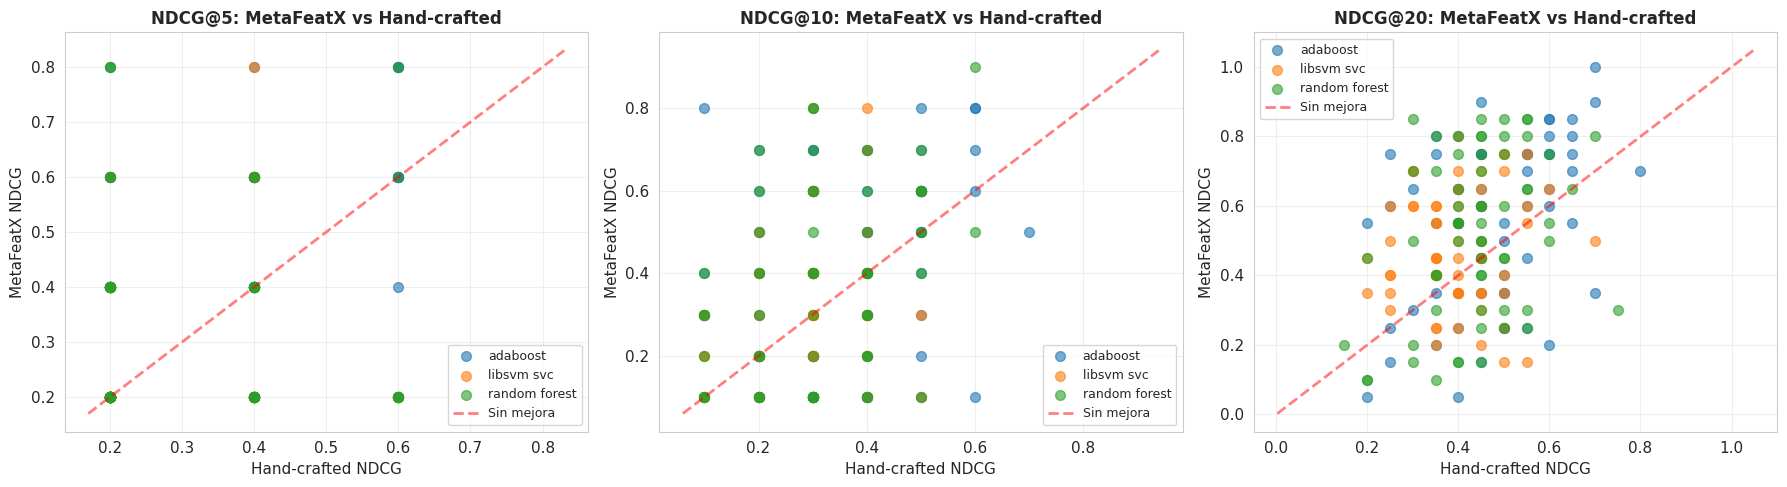

In [28]:
# 4. Distribución de diferencias (scatter plot)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, k in enumerate([5, 10, 20]):
    ax = axes[idx]
    
    for pipeline in sorted(df['pipeline'].unique()):
        mf_subset = df[(df['pipeline'] == pipeline) & (df['feature_type'] == 'metafeatx')]
        hc_subset = df[(df['pipeline'] == pipeline) & (df['feature_type'] == 'handcrafted')]
        
        # Merge por task_id para comparar pareado
        merged = pd.merge(mf_subset[['task_id', f'ndcg@{k}']], 
                         hc_subset[['task_id', f'ndcg@{k}']], 
                         on='task_id', suffixes=('_mf', '_hc'))
        
        ax.scatter(merged[f'ndcg@{k}_hc'], merged[f'ndcg@{k}_mf'], 
                  label=pipeline.replace('_', ' '), alpha=0.6, s=50)
    
    # Línea diagonal (sin mejora)
    max_val = max([ax.get_xlim()[1], ax.get_ylim()[1]])
    min_val = min([ax.get_xlim()[0], ax.get_ylim()[0]])
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, linewidth=2, label='Sin mejora')
    
    ax.set_xlabel('Hand-crafted NDCG', fontsize=11)
    ax.set_ylabel('MetaFeatX NDCG', fontsize=11)
    ax.set_title(f'NDCG@{k}: MetaFeatX vs Hand-crafted', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Análisis por Tarea


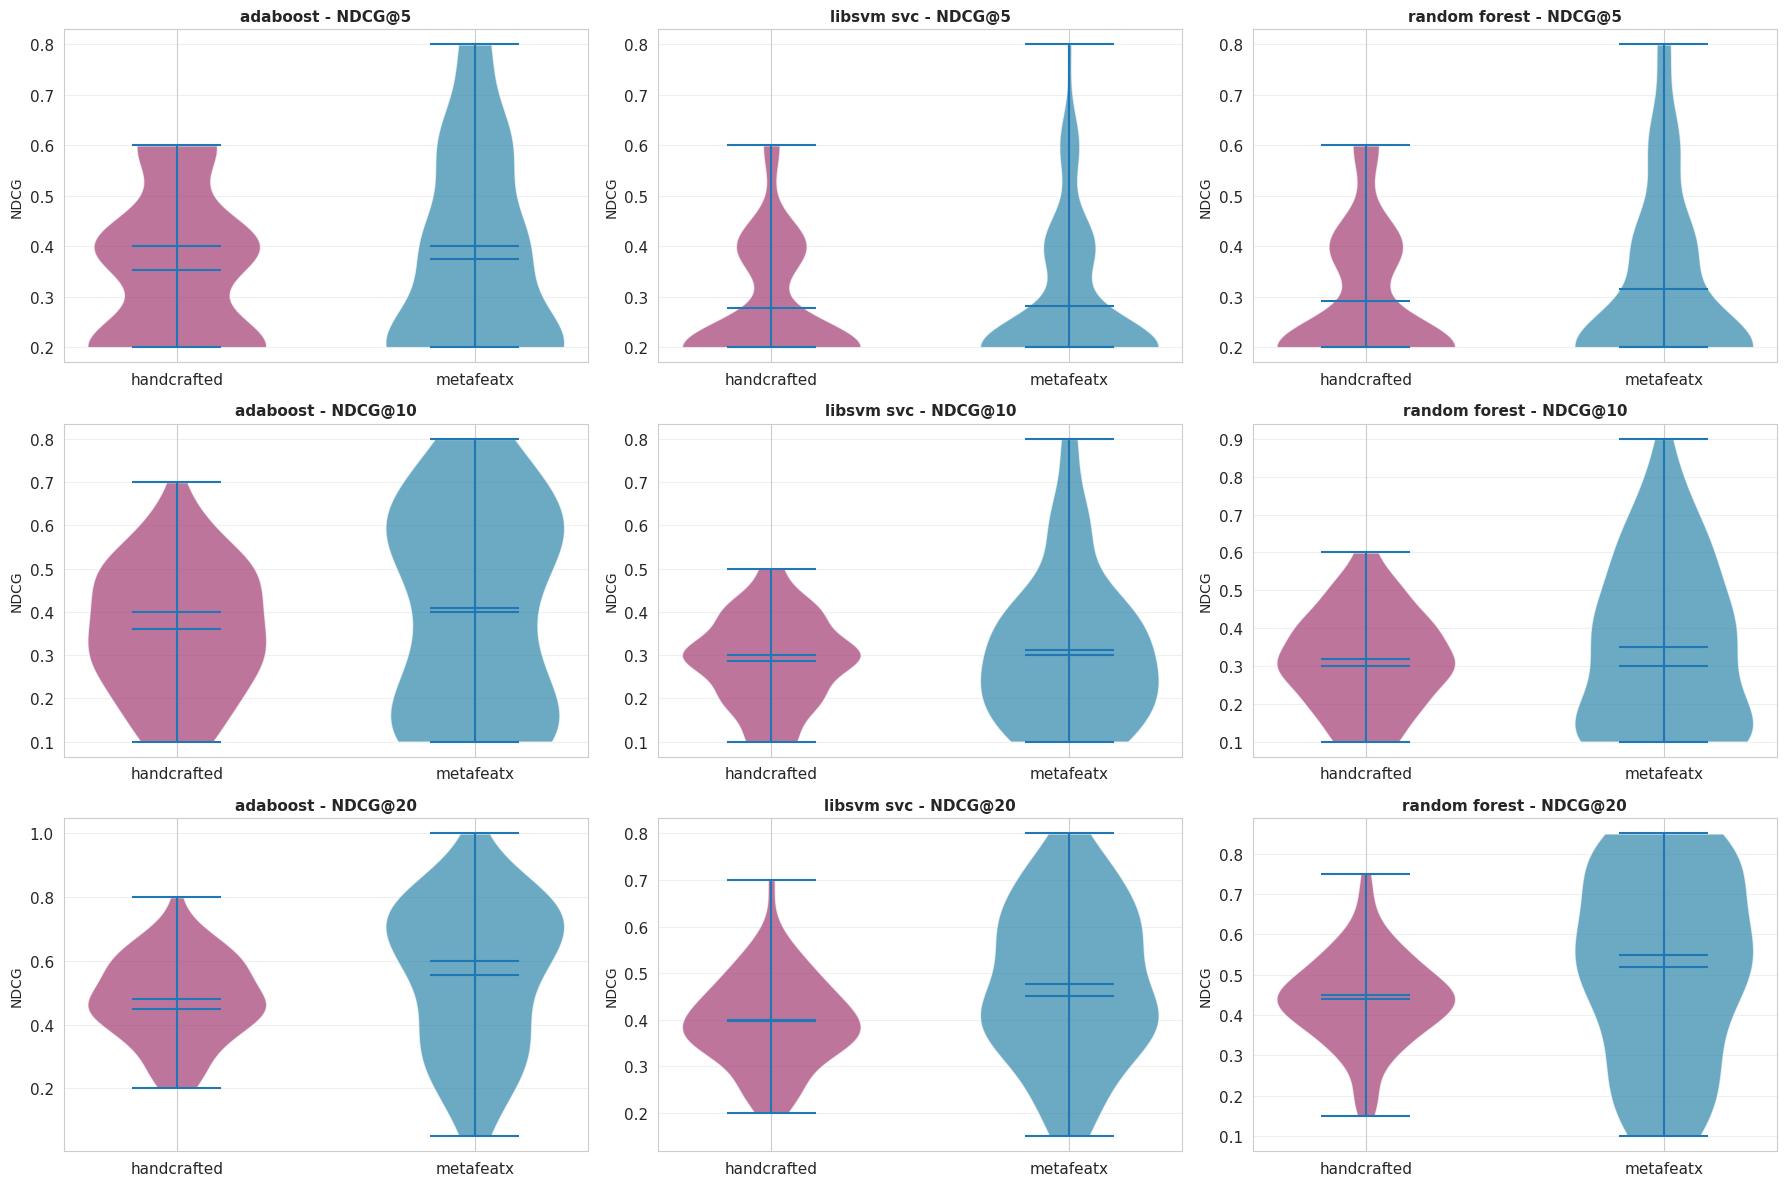

In [29]:
# 5. Violin plots para mostrar distribuciones
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

for row, k in enumerate([5, 10, 20]):
    for col, pipeline in enumerate(sorted(df['pipeline'].unique())):
        ax = axes[row, col]
        
        data_to_plot = []
        labels_plot = []
        
        for feature_type in ['handcrafted', 'metafeatx']:
            subset = df[(df['pipeline'] == pipeline) & (df['feature_type'] == feature_type)]
            if not subset.empty:
                data_to_plot.append(subset[f'ndcg@{k}'].values)
                labels_plot.append(feature_type.replace('_', '-'))
        
        parts = ax.violinplot(data_to_plot, positions=range(len(data_to_plot)), 
                             widths=0.6, showmeans=True, showmedians=True)
        
        # Colorear violines
        for i, pc in enumerate(parts['bodies']):
            if labels_plot[i] == 'metafeatx':
                pc.set_facecolor(COLORS['metafeatx'])
            else:
                pc.set_facecolor(COLORS['handcrafted'])
            pc.set_alpha(0.7)
        
        ax.set_xticks(range(len(labels_plot)))
        ax.set_xticklabels(labels_plot)
        ax.set_ylabel('NDCG', fontsize=10)
        ax.set_title(f'{pipeline.replace("_", " ")} - NDCG@{k}', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [30]:
# Identificar tareas con mayores y menores mejoras
task_analysis = []

for pipeline in df['pipeline'].unique():
    mf_subset = df[(df['pipeline'] == pipeline) & (df['feature_type'] == 'metafeatx')]
    hc_subset = df[(df['pipeline'] == pipeline) & (df['feature_type'] == 'handcrafted')]
    
    merged = pd.merge(mf_subset[['task_id', 'ndcg@5', 'ndcg@10', 'ndcg@20']], 
                     hc_subset[['task_id', 'ndcg@5', 'ndcg@10', 'ndcg@20']], 
                     on='task_id', suffixes=('_mf', '_hc'))
    
    for k in [5, 10, 20]:
        merged[f'improvement_{k}'] = merged[f'ndcg@{k}_mf'] - merged[f'ndcg@{k}_hc']
    
    merged['pipeline'] = pipeline
    task_analysis.append(merged)

task_df = pd.concat(task_analysis, ignore_index=True)

# Tareas con mayores mejoras
print("="*70)
print("TOP 10 TAREAS CON MAYORES MEJORAS (NDCG@20)")
print("="*70)
top_improvements = task_df.nlargest(10, 'improvement_20')[['pipeline', 'task_id', 'ndcg@20_mf', 'ndcg@20_hc', 'improvement_20']]
print(top_improvements.to_string(index=False))


TOP 10 TAREAS CON MAYORES MEJORAS (NDCG@20)
     pipeline  task_id  ndcg@20_mf  ndcg@20_hc  improvement_20
random_forest     9977        0.85        0.30            0.55
     adaboost    14965        0.75        0.25            0.50
     adaboost    14969        0.80        0.35            0.45
random_forest     3903        0.80        0.35            0.45
     adaboost     2079        0.90        0.45            0.45
     adaboost       11        0.75        0.35            0.40
     adaboost     3560        0.80        0.40            0.40
random_forest     3913        0.80        0.40            0.40
   libsvm_svc       53        0.80        0.40            0.40
random_forest     9976        0.70        0.30            0.40


In [31]:
# Resumen de mejoras por algoritmo
print("="*70)
print("RESUMEN DE MEJORAS POR ALGORITMO")
print("="*70)

for pipeline in sorted(task_df['pipeline'].unique()):
    subset = task_df[task_df['pipeline'] == pipeline]
    print(f"\n{pipeline.upper()}:")
    print(f"  Tareas con mejora en NDCG@20: {(subset['improvement_20'] > 0).sum()} / {len(subset)} ({(subset['improvement_20'] > 0).mean()*100:.1f}%)")
    print(f"  Mejora promedio: {subset['improvement_20'].mean():.4f}")
    print(f"  Mejora máxima:   {subset['improvement_20'].max():.4f}")
    print(f"  Mejora mínima:   {subset['improvement_20'].min():.4f}")


RESUMEN DE MEJORAS POR ALGORITMO

ADABOOST:
  Tareas con mejora en NDCG@20: 37 / 64 (57.8%)
  Mejora promedio: 0.0758
  Mejora máxima:   0.5000
  Mejora mínima:   -0.4000

LIBSVM_SVC:
  Tareas con mejora en NDCG@20: 43 / 64 (67.2%)
  Mejora promedio: 0.0797
  Mejora máxima:   0.4000
  Mejora mínima:   -0.4000

RANDOM_FOREST:
  Tareas con mejora en NDCG@20: 40 / 64 (62.5%)
  Mejora promedio: 0.0805
  Mejora máxima:   0.5500
  Mejora mínima:   -0.4500


In [ ]:
print("="*70)
print("CONCLUSIONES DEL TASK 1 ASSESSMENT")
print("="*70)
print("\n1. MEJORAS GENERALES:")
for k in [5, 10, 20]:
    overall_improvement = comparison_df[comparison_df['k'] == k]['improvement_pct'].mean()
    print(f"   - NDCG@{k}: Mejora promedio de {overall_improvement:+.2f}%")

print("\n2. SIGNIFICANCIA ESTADÍSTICA:")
for k in [5, 10, 20]:
    significant = comparison_df[(comparison_df['k'] == k) & (comparison_df['p_value_w'] < 0.05)]
    print(f"   - NDCG@{k}: {len(significant)}/3 algoritmos con mejoras estadísticamente significativas")

print("\n3. MEJORES RESULTADOS:")
best = comparison_df.loc[comparison_df['improvement_pct'].idxmax()]
print(f"   - Algoritmo: {best['pipeline']}")
print(f"   - Métrica: NDCG@{int(best['k'])}")
print(f"   - Mejora: {best['improvement_pct']:.2f}%")
print(f"   - Significancia: {best['significant_w']}")

print("\n4. CONSISTENCIA:")
consistent = comparison_df[(comparison_df['improvement'] > 0) & (comparison_df['k'] == 20)]
print(f"   - MetaFeatX supera Hand-crafted en NDCG@20 para {len(consistent)}/3 algoritmos")

print("\n" + "="*70)


In [32]:
# Resumen de mejoras por algoritmo
print("="*70)
print("RESUMEN DE MEJORAS POR ALGORITMO")
print("="*70)

for pipeline in sorted(task_df['pipeline'].unique()):
    subset = task_df[task_df['pipeline'] == pipeline]
    print(f"\n{pipeline.upper()}:")
    print(f"  Tareas con mejora en NDCG@20: {(subset['improvement_20'] > 0).sum()} / {len(subset)} ({(subset['improvement_20'] > 0).mean()*100:.1f}%)")
    print(f"  Mejora promedio: {subset['improvement_20'].mean():.4f}")
    print(f"  Mejora máxima:   {subset['improvement_20'].max():.4f}")
    print(f"  Mejora mínima:   {subset['improvement_20'].min():.4f}")


RESUMEN DE MEJORAS POR ALGORITMO

ADABOOST:
  Tareas con mejora en NDCG@20: 37 / 64 (57.8%)
  Mejora promedio: 0.0758
  Mejora máxima:   0.5000
  Mejora mínima:   -0.4000

LIBSVM_SVC:
  Tareas con mejora en NDCG@20: 43 / 64 (67.2%)
  Mejora promedio: 0.0797
  Mejora máxima:   0.4000
  Mejora mínima:   -0.4000

RANDOM_FOREST:
  Tareas con mejora en NDCG@20: 40 / 64 (62.5%)
  Mejora promedio: 0.0805
  Mejora máxima:   0.5500
  Mejora mínima:   -0.4500


In [33]:
print("="*70)
print("CONCLUSIONES DEL TASK 1 ASSESSMENT")
print("="*70)
print("\n1. MEJORAS GENERALES:")
for k in [5, 10, 20]:
    overall_improvement = comparison_df[comparison_df['k'] == k]['improvement_pct'].mean()
    print(f"   - NDCG@{k}: Mejora promedio de {overall_improvement:+.2f}%")

print("\n2. SIGNIFICANCIA ESTADÍSTICA:")
for k in [5, 10, 20]:
    significant = comparison_df[(comparison_df['k'] == k) & (comparison_df['p_value_w'] < 0.05)]
    print(f"   - NDCG@{k}: {len(significant)}/3 algoritmos con mejoras estadísticamente significativas")

print("\n3. MEJORES RESULTADOS:")
best = comparison_df.loc[comparison_df['improvement_pct'].idxmax()]
print(f"   - Algoritmo: {best['pipeline']}")
print(f"   - Métrica: NDCG@{int(best['k'])}")
print(f"   - Mejora: {best['improvement_pct']:.2f}%")
print(f"   - Significancia: {best['significant_w']}")

print("\n4. CONSISTENCIA:")
consistent = comparison_df[(comparison_df['improvement'] > 0) & (comparison_df['k'] == 20)]
print(f"   - MetaFeatX supera Hand-crafted en NDCG@20 para {len(consistent)}/3 algoritmos")

print("\n" + "="*70)


CONCLUSIONES DEL TASK 1 ASSESSMENT

1. MEJORAS GENERALES:
   - NDCG@5: Mejora promedio de +5.31%
   - NDCG@10: Mejora promedio de +10.98%
   - NDCG@20: Mejora promedio de +18.06%

2. SIGNIFICANCIA ESTADÍSTICA:
   - NDCG@5: 0/3 algoritmos con mejoras estadísticamente significativas
   - NDCG@10: 0/3 algoritmos con mejoras estadísticamente significativas
   - NDCG@20: 3/3 algoritmos con mejoras estadísticamente significativas

3. MEJORES RESULTADOS:
   - Algoritmo: libsvm_svc
   - Métrica: NDCG@20
   - Mejora: 20.04%
   - Significancia: **

4. CONSISTENCIA:
   - MetaFeatX supera Hand-crafted en NDCG@20 para 3/3 algoritmos

